# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


## Project Overview

Customer satisfaction drives business success and data analytics provides insight into what customers think. For example, the phrase "[360-degree customer view](https://searchsalesforce.techtarget.com/definition/360-degree-customer-view)" refers to aggregating data describing a customer's purchases and customer service interactions. 

The Starbucks Udacity Data Scientist Nanodegree Capstone challenge data set is a simulation of customer behavior on the Starbucks rewards mobile application. Periodically, Starbucks sends offers to users that may be an advertisement, discount, or buy one get one free (BOGO). An important characteristic regarding this dataset is that not all users receive the same offer.

This data set contains three files. The first file describes the characteristics of each offer, including its duration and the amount a customer needs to spend to complete it (difficulty). The second file contains customer demographic data including their age, gender, income, and when they created an account on the Starbucks rewards mobile application. The third file describes customer purchases and when they received, viewed, and completed an offer. An offer is only successful when a customer both views an offer and meets or exceeds its difficulty within the offer's duration.

## Problem Statement

The problem that I chose to solve was to build a model that predicts whether a customer will respond to an offer or not. 

## Data Cleaning
- Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV

%matplotlib inline

### Read the Starbucks challenge data
* portfolio.json - Contains offer identifiers and offer meta data (e.g. duration, type, etc.)
* profile.json - Customer demographic data
* transcript.json - Describes customer transactions and when offers are received, viewed, and completed.

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Data Cleaning: Offer portfolio 
- Offer record attributes
    * id (string) - Offer id
    * offer_type (string) - String that describes the offer type
        * bogo (Buy One Get One Free)  
        * discount
        * informational
    * difficulty (int) - Minimum amount a customer must spend to complete an offer
    * reward (int) - Reward given for completing an offer
    * duration (int) - Offer duration [days]  
    * channels (list of strings)

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
portfolio.shape

(10, 6)

In [6]:
#Check for null values
portfolio.isna().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [7]:
#extract all channels names 
channels_set = set()
for i in portfolio.channels:
    channels_set.update(set(i))
channels_set

{'email', 'mobile', 'social', 'web'}

In [8]:
# split the channel into different attribute
for i in channels_set:
    portfolio[i] = portfolio.channels.apply(lambda x: i in x).map({True:1, False: 0})
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,web,social,mobile,email
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,0,1,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,1,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [9]:
# Now drop the 'offer_type' & 'channels' column 
#portfolio = portfolio.drop('offer_type', axis=1)
portfolio = portfolio.drop('channels', axis=1)
portfolio

,difficulty,duration,id,offer_type,reward,web,social,mobile,email
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,0,1,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,0,1,1


### data Cleaning: Customer profile data 
- Customer profile record attributes  
    * age (int) - Customer age
    * became_member_on (int) - Date when customer created an app account
    * gender (str) - Customer gender (note some entries contain 'O' for other rather than M or F)  
    * id (str) - Customer id
    * income (float) - Customer's income  
- Customer profile EDA conclusions
    - Gender and income have ~ 13% missing data  
        - Age is 118 when income is NaN  
    - Gender is not specified for ~ 1.5% of the data  
    - Year that a customer became a rewards member is not uniformly distributed - potential customer differentiator
    - Month that a customer became a rewards member is approximately uniformly distributed - probably not a useful feature to include  

In [10]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [12]:
profile.shape

(17000, 5)

In [13]:
#Check for null values
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [14]:
profile.isnull().sum(axis=0) * 100 / profile.shape[0]

age                  0.000000
became_member_on     0.000000
gender              12.794118
id                   0.000000
income              12.794118
dtype: float64

In [15]:
gender_counts = profile['gender'].value_counts()
gender_counts *= 100 / gender_counts.sum()
gender_counts

M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64

For the income we can replace null values with avg, and for gender lets drop it.

In [16]:
profile['gender'].fillna('NA', inplace=True)
profile['income'].fillna((profile['income'].mean()), inplace=True)

In [17]:
#profile.dropna(inplace=True)

In [18]:
profile

,age,became_member_on,gender,id,income
0,118,20170212,NA,68be06ca386d4c31939f3a4f0e3dd783,65404.991568
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.000000
2,118,20180712,NA,38fe809add3b4fcf9315a9694bb96ff5,65404.991568
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000
4,118,20170804,NA,a03223e636434f42ac4c3df47e8bac43,65404.991568
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.000000
6,118,20170925,NA,8ec6ce2a7e7949b1bf142def7d0e0586,65404.991568
7,118,20171002,NA,68617ca6246f4fbc85e91a2a49552598,65404.991568
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.000000
9,118,20161122,NA,8974fc5686fe429db53ddde067b88302,65404.991568


### Data Cleaning: Transaction data
- Customer transaction record attributes
    * event (str) - Record description (i.e. transaction, offer received, offer viewed, etc.)
    * person (str) - Customer id
    * time (int) - Time in hours. The data begins at time t=0
    * value - (dict of strings) - Either an offer id or transaction amount depending on the record
- Customer transaction data EDA conclusions  
    - Need to separate offer and customer purchase data  
    - Results suggest ~ 45 % of the events are customers purchases and ~ 55% of the events describe customer offers 

In [19]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [20]:
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [21]:
# find different keys in value column
keys = []
for idx, row in transcript.iterrows():
    for k in row['value']:
        if k in keys:
            continue
        else:
            keys.append(k)

keys

['offer id', 'amount', 'offer_id', 'reward']

In [22]:
# Iterate over transcript table, check value column and update it, put each key in seperated column.
transcript['offer_id'] = ''
transcript['amount'] = 0
transcript['reward'] = 0

for idx, row in transcript.iterrows():
    for k in row['value']:
        if k == 'offer_id' or k == 'offer id':
            transcript.at[idx, 'offer_id']= row['value'][k]
        if k == 'amount':
            transcript.at[idx, 'amount']= row['value'][k]
        if k == 'reward':
            transcript.at[idx, 'reward']= row['value'][k]

In [23]:
transcript = transcript.drop('value', axis=1)
transcript.head()

,event,person,time,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


Now everything looks good for data Analysis and Modeling.
Lets do this..

## Analyzing Data

### Most common promotion

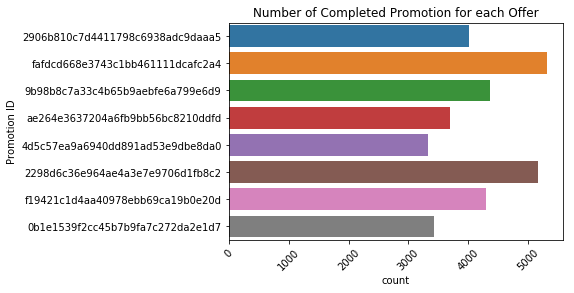

In [24]:
# We check the completed orders only
completed_off_count = transcript[transcript['event'] == 'offer completed']

sns.countplot(y=completed_off_count['offer_id'])
plt.title('Number of Completed Promotion for each Offer')
plt.ylabel('Promotion ID')
plt.xticks(rotation = 45)
plt.show();

Above plot shows the promotion offers wich did great.

### Plot offer type vs complition ans count 
Result shows the offers which got completed successfully. 

In [25]:
def get_offer_type(offer_id):
    '''
    input: offer_id: id of offer
    
    output: offer type
    
    '''
    
    try:
        offer_type = portfolio[portfolio['id'] == offer_id]['offer_type'].values[0]
        return offer_type
    except:
        offer_type = 'NA'
        return offer_type

transcript['offer_type'] = transcript.apply(lambda x: get_offer_type(x['offer_id']), axis=1)

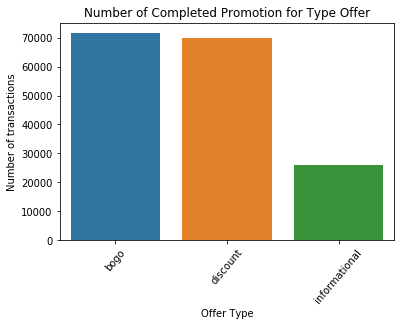

In [26]:
sns.countplot(transcript[transcript['offer_type'] != 'NA']['offer_type'])
plt.title('Number of Completed Promotion for Type Offer')
plt.ylabel('Number of transactions')
plt.xlabel('Offer Type')
plt.xticks(rotation = 50)
plt.show();

### Plot Income Distribution as a Function of Gender  
Results suggest that the minimum and maximum income for both male and female customers is approximately the same. However, male customer income is slightly biased towards lower values compared to female customer income.

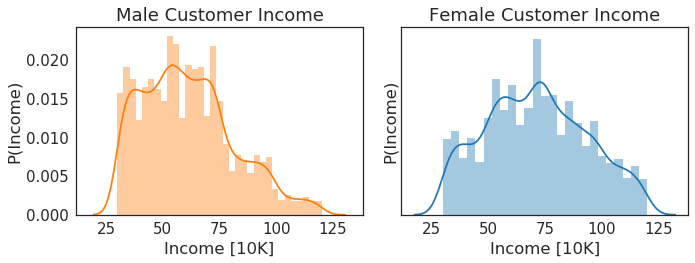

In [27]:
male_customers = profile[profile['gender'] == 'M']
female_customers = profile[profile['gender'] == 'F']

current_palette = sns.color_palette()

sns.set(font_scale=1.5)
sns.set_style('white')

fig, ax = plt.subplots(figsize=(10, 4),
                       nrows=1,
                       ncols=2,
                       sharex=True,
                       sharey=True)

plt.sca(ax[0])
sns.distplot(male_customers['income'] * 1E-3,
             color=current_palette[1])
plt.xlabel('Income [10K]')
plt.ylabel('P(Income)')
plt.title('Male Customer Income')

plt.sca(ax[1])
sns.distplot(female_customers['income'] * 1E-3,
             color=current_palette[0])
plt.xlabel('Income [10K]')
plt.ylabel('P(Income)')
plt.title('Female Customer Income')
plt.tight_layout()

### Evaluate Age Range Statistics  
These results suggest that the average customer age is between 50 and 60 years old and male customer count is more. 

gender
F    AxesSubplot(0.125,0.125;0.775x0.755)
M    AxesSubplot(0.125,0.125;0.775x0.755)
O    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

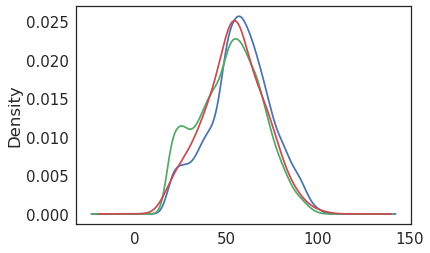

In [28]:
profile[profile['gender'] != 'NA'].groupby('gender').age.plot(kind='kde')

In [29]:
profile['age_groups'] = pd.cut(profile.age, bins=[0, 12, 20, 30, 64, 110], 
                               labels=['kid', 'teen', 'young adult', 'adult', 'elderly'])

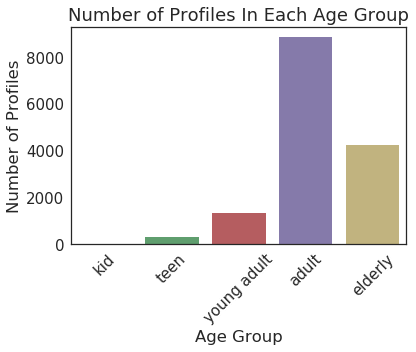

In [30]:
sns.countplot(x='age_groups', data=profile)
plt.title('Number of Profiles In Each Age Group')
plt.ylabel('Number of Profiles')
plt.xlabel('Age Group')
plt.xticks(rotation = 45)
plt.show();

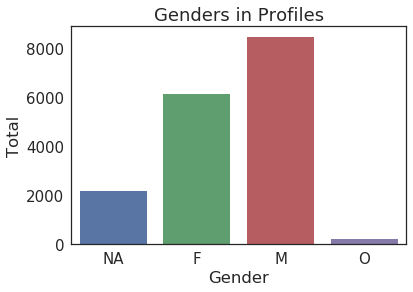

In [31]:
sns.countplot(profile['gender'])
plt.title('Genders in Profiles')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

### Evaluate customers with higest transcript 

In [32]:
loyal_customer_count = transcript[(transcript['event'] == 'offer completed') | (transcript['event'] == 'transaction')].groupby(['person', 'event'])['amount'].sum().reset_index()
loyal_customer_count = loyal_customer_count.sort_values('amount', ascending=False).head(10)
count = 1

for idx, row in loyal_customer_count.iterrows():
    print(f'.------------------- [ #{count} ] ------------------.')
    print(f'| Profile ID: {row["person"]} |')
    print(f'| Number of Completed Offers:       {completed_off_count[(completed_off_count["person"] == row["person"]) & (completed_off_count["event"] == "offer completed")].shape[0]}          |')
    print(f'| Amount:                         ${row["amount"]}        |')
    print(f"'----------------------------------------------'")
    count += 1

.------------------- [ #1 ] ------------------.
| Profile ID: 3c8d541112a74af99e88abbd0692f00e |
| Number of Completed Offers:       5          |
| Amount:                         $1606        |
'----------------------------------------------'
.------------------- [ #2 ] ------------------.
| Profile ID: f1d65ae63f174b8f80fa063adcaa63b7 |
| Number of Completed Offers:       6          |
| Amount:                         $1360        |
'----------------------------------------------'
.------------------- [ #3 ] ------------------.
| Profile ID: ae6f43089b674728a50b8727252d3305 |
| Number of Completed Offers:       3          |
| Amount:                         $1320        |
'----------------------------------------------'
.------------------- [ #4 ] ------------------.
| Profile ID: 626df8678e2a4953b9098246418c9cfa |
| Number of Completed Offers:       4          |
| Amount:                         $1314        |
'----------------------------------------------'
.------------------- [ #

most popular promotion for children, teens, young adult, adult and elderly customers

In [33]:
#get age group from profile dataframe
def get_customer_age_group(profile_id):
    age_group = profile[profile['id'] == profile_id]['age_groups'].values[0]
    return age_group

transcript['age_group'] = transcript.apply(lambda x: get_customer_age_group(x['person']), axis=1)

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:1518: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 76436 but corresponding boolean dimension is 43268
  stat_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:1518: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 162745 but corresponding boolean dimension is 89578
  stat_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:1518: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 27037 but corresponding boolean dimension is 12853
  stat_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:1518: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 6544 but corresponding boolean d

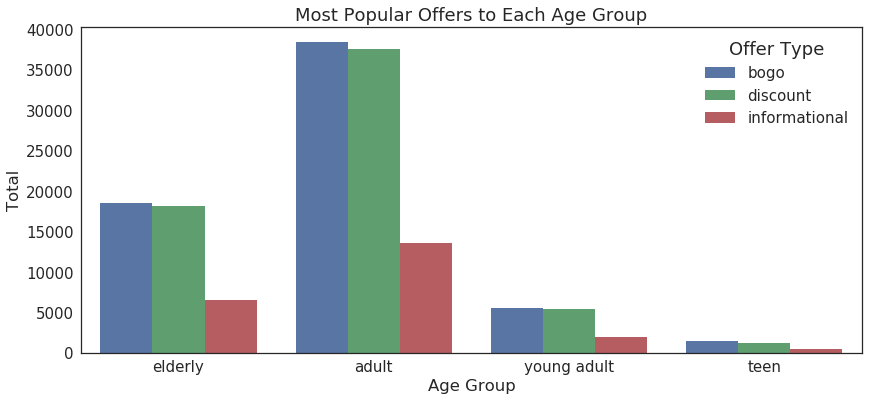

In [38]:
plt.figure(figsize=(14, 6))
sns.countplot(x="age_group", hue=transcript[transcript['offer_type'] != 'NA']['offer_type'], data=transcript)
plt.title('Most Popular Offers to Each Age Group')
plt.ylabel('Total')
plt.xlabel('Age Group')
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

### Promotions liked by Gender
Result suggest that offer type = "Bogo" is more prefered by both Male and Female.

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:1518: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2175 but corresponding boolean dimension is 2038
  stat_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:1518: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 6129 but corresponding boolean dimension is 5759
  stat_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:1518: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 8484 but corresponding boolean dimension is 7913
  stat_data = remove_na(group_data[hue_mask])
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:1518: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 212 but corresponding boolean dimension

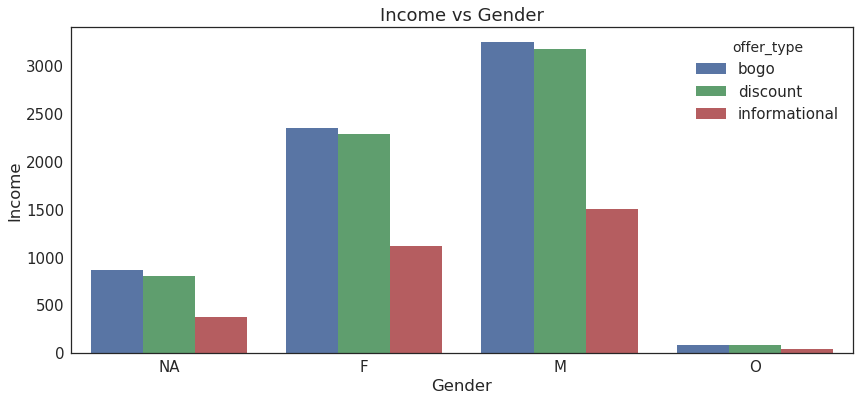

In [39]:
plt.figure(figsize=(14, 6))
sns.countplot(x=profile['gender'], hue = transcript[transcript['offer_type'] != 'NA']['offer_type'], data=transcript)
plt.title('Income vs Gender')
plt.ylabel('Income')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

## Modeling Data

In [36]:
#Because my model will guess the offer_type, I will only get those transcripts with offer id's.
transcript = transcript[transcript['offer_id'] != 'NA']

We need to add gender and income to transcrip so we can use all we need in one file here

In [40]:
def get_customer_gender(profile_id):
    gender = profile[profile['id'] == profile_id]['gender'].values[0]
    return gender

transcript['gender'] = transcript.apply(lambda x: get_customer_gender(x['person']), axis=1)

In [41]:
def get_customer_income(profile_id):
    income = profile[profile['id'] == profile_id]['income'].values[0]
    return income

transcript['income'] = transcript.apply(lambda x: get_customer_income(x['person']), axis=1)

In [42]:
transcript.head()

,event,person,time,offer_id,amount,reward,offer_type,age_group,gender,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,bogo,elderly,F,100000.000000
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,discount,NaN,NA,65404.991568
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0,discount,elderly,M,70000.000000
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0,discount,NaN,NA,65404.991568
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,bogo,NaN,NA,65404.991568


In [43]:
transcript.dropna(how="any", inplace=True)

In [44]:
transcript.head()

,event,person,time,offer_id,amount,reward,offer_type,age_group,gender,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,bogo,elderly,F,100000.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0,discount,elderly,M,70000.0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0,0,bogo,elderly,M,53000.0
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0,0,informational,adult,M,51000.0
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,discount,adult,F,57000.0


Now we should split our dataframe to features and target

In [45]:
#Features
# reference: https://www.datacamp.com/community/tutorials/categorical-data
labels_event = transcript['event'].astype('category').cat.categories.tolist()
replace_map_comp_event = {'event' : {k: v for k,v in zip(labels_event,list(range(1,len(labels_event)+1)))}}
print(replace_map_comp_event)

labels_offer_id = transcript['offer_id'].astype('category').cat.categories.tolist()
replace_map_comp_offer_id = {'offer_id' : {k: v for k,v in zip(labels_offer_id,list(range(1,len(labels_offer_id)+1)))}}
print(replace_map_comp_offer_id)

labels_age_group = transcript['age_group'].astype('category').cat.categories.tolist()
replace_map_comp_age_group = {'age_group' : {k: v for k,v in zip(labels_age_group,list(range(1,len(labels_age_group)+1)))}}
print(replace_map_comp_age_group)

labels_gender = transcript['gender'].astype('category').cat.categories.tolist()
replace_map_comp_gender = {'gender' : {k: v for k,v in zip(labels_gender,list(range(1,len(labels_gender)+1)))}}
print(replace_map_comp_gender)

{'event': {'offer completed': 1, 'offer received': 2, 'offer viewed': 3, 'transaction': 4}}
{'offer_id': {'': 1, '0b1e1539f2cc45b7b9fa7c272da2e1d7': 2, '2298d6c36e964ae4a3e7e9706d1fb8c2': 3, '2906b810c7d4411798c6938adc9daaa5': 4, '3f207df678b143eea3cee63160fa8bed': 5, '4d5c57ea9a6940dd891ad53e9dbe8da0': 6, '5a8bc65990b245e5a138643cd4eb9837': 7, '9b98b8c7a33c4b65b9aebfe6a799e6d9': 8, 'ae264e3637204a6fb9bb56bc8210ddfd': 9, 'f19421c1d4aa40978ebb69ca19b0e20d': 10, 'fafdcd668e3743c1bb461111dcafc2a4': 11}}
{'age_group': {'adult': 1, 'elderly': 2, 'teen': 3, 'young adult': 4}}
{'gender': {'F': 1, 'M': 2, 'O': 3}}


In [46]:
#Targets
labels_offer_type = transcript['offer_type'].astype('category').cat.categories.tolist()
replace_map_comp_offer_type = {'offer_type' : {k: v for k,v in zip(labels_offer_type,list(range(1,len(labels_offer_type)+1)))}}
print(replace_map_comp_offer_type)

{'offer_type': {'NA': 1, 'bogo': 2, 'discount': 3, 'informational': 4}}


In [47]:
# replace categorical with numerical
transcript.replace(replace_map_comp_event, inplace=True)
transcript.replace(replace_map_comp_offer_id, inplace=True)
transcript.replace(replace_map_comp_age_group, inplace=True)
transcript.replace(replace_map_comp_gender, inplace=True)

transcript.replace(replace_map_comp_offer_type, inplace=True)

In [48]:
# Split the data into features and target label
target = transcript['offer_type']
features = transcript.drop(['person', 'offer_type'], axis = 1)

In [49]:
target.head()

0    2
2    3
5    2
7    4
8    3
Name: offer_type, dtype: int64

In [50]:
features.head()

,event,time,offer_id,amount,reward,age_group,gender,income
0,2,0,8,0,0,2,1,100000.0
2,2,0,4,0,0,2,2,70000.0
5,2,0,10,0,0,2,2,53000.0
7,2,0,5,0,0,1,2,51000.0
8,2,0,2,0,0,1,1,57000.0


We should normalize the numerical values (time, amount, reward, income) because we will use them as features.

In [51]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
to_normalize = ['time', 'amount', 'reward', 'income']

features[to_normalize] = scaler.fit_transform(features[to_normalize])
features.head()

,event,time,offer_id,amount,reward,age_group,gender,income
0,2,0.0,8,0.0,0.0,2,1,0.777778
2,2,0.0,4,0.0,0.0,2,2,0.444444
5,2,0.0,10,0.0,0.0,2,2,0.255556
7,2,0.0,5,0.0,0.0,1,2,0.233333
8,2,0.0,2,0.0,0.0,1,1,0.300000


Create Train and Test dataset

In [52]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=5)

In [53]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (204571, 8)
Training Labels Shape: (204571,)
Testing Features Shape: (68191, 8)
Testing Labels Shape: (68191,)



## Metrics

Since we have a simple classification problem, I will use accuracy to evaluate my models. We want to see how well our model by seeing the number of correct predictions vs total number of predicitons.

Why choose accuracy? First let's define accuracy, the ratio of the correctly labeled subjects to the whole pool of subjects. Also, accuracy answers questions like: How many students did we correctly label out of all the students? It's similar to our situation right? because we want to see how many customers use Starbucks offers. Furthermore, Accuracy = (TP+TN)/(TP+FP+FN+TN). Not to forget, that this is a simple classification problem, so this is my opinion and reasoning on why to use the easiest (accuracy).

Reference: https://towardsdatascience.com/accuracy-recall-precision-f-score-specificity-which-to-optimize-on-867d3f11124 https://medium.com/thalus-ai/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b


### Logistic Regression

In [54]:
# reference: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
def pred_score(model):
    pred = model.predict(X_test)
    # Calculate the absolute errors
    errors = abs(pred - y_test)
    # Calculate mean absolute percentage error
    mape = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mape)
    return round(accuracy, 2)

In [55]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

logreg.fit(X_train, y_train)
print(f'Accuracy of Logistic regression classifier on training set: {round(logreg.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(logreg)}%')

Accuracy of Logistic regression classifier on training set: 80.56%.
Prediction Accuracy: 92.73%


### K-Nearest Neighbors

In [56]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
print(f'Accuracy of K-NN classifier on training set: {round(knn.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(knn)}%')

Accuracy of K-NN classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


### Decision Tree

In [57]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)
print(f'Accuracy of Decision Tree classifier on training set: {round(dt.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(dt)}%')

Accuracy of Decision Tree classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


### Support Vector Machine

In [58]:
from sklearn.svm import SVC

svm = SVC()

svm.fit(X_train, y_train)
print(f'Accuracy of SVM classifier on training set: {round(svm.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(svm)}%')

Accuracy of SVM classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


### Random Forest

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score

rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f'Accuracy of SVM classifier on training set: {round(rf.score(X_train, y_train)*100,2)}%.')
print(f1_score(y_test, y_pred, average="macro"))

Accuracy of SVM classifier on training set: 100.0%.
1.0


### Naive Bayes

In [60]:
from sklearn.naive_bayes import GaussianNB 

gnb = GaussianNB() 
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print(f'Accuracy of SVM classifier on training set: {round(gnb.score(X_train, y_train)*100,2)}%.')
print(f1_score(y_test, y_pred, average="macro"))

Accuracy of SVM classifier on training set: 73.42%.
0.631413631457


## Models Results

In [61]:
# reference: https://stackoverflow.com/a/52768022
models = [logreg, knn, dt, svm, rf, gnb]
model_names = [type(n).__name__ for n in models]
tr_accuracy = [x.score(X_train, y_train)*100 for x in models]
pred_accuracy = [pred_score(y) for y in models]

In [62]:
results = [tr_accuracy, pred_accuracy]
results_df = pd.DataFrame(results, columns = model_names, index=['Training Accuracy', 'Predicting Accuracy']) 
results_df

,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier,SVC,RandomForestRegressor,GaussianNB
Training Accuracy,80.555406,100.0,100.0,100.0,100.0,73.419986
Predicting Accuracy,92.730000,100.0,100.0,100.0,100.0,78.960000


Based on the above table, we can see that we scored 100% accuracy in the training and testing datasets on 4 models. To avoid overfitting I will choose Logistic Regression since it got good results 80.5% on training and 92.8% on testing datasets. Logistic Regression is better used here since we have few binomial outcomes ( BOGO = 2, discount = 3, informational = 4 ). It is good here because we have good amount of data to work with.

## Model Improvements

In [63]:
# Tuning to get better accuracy(Takes arround 70 mins to finish)
dual = [True, False]
max_iter = [100, 120, 140, 160, 180, 200, 220]
C = [1.0,1.5,2.0,2.5,3.0,3.5,4.0]
param_grid = dict(dual = dual, max_iter = max_iter, C = C)

lr = LogisticRegression(random_state=42)
grid = GridSearchCV(estimator = lr, param_grid = param_grid, cv = 3, n_jobs = -1)
grid_result = grid.fit(X_train, y_train)

print(f'Best Score: {grid_result.best_score_}')
print(f'Best params: {grid_result.best_params_}')

Best Score: 0.8263781278871394
Best params: {'C': 4.0, 'dual': True, 'max_iter': 100}


Looks like an imporvment of ~1.5. Will try more to improve the prediction scores.

## Conclusion

In this project, I tried to analyze and make model to predict the best offer to give a Starbucks customer. First I explored the data and see what I have to change before start the analysis. Then I did some exploratory analysis on the data after cleaning. In conclusion, the company should give more offers to Females than Males since they have more completed offers. And they should focus more on BOGO and Discount offers since they are the one that tend to make customers buy more.


## Improvements
Though I ggot a good result and accuracy the models can be improved by providing more collection of data and selecting more features like when customer created their accounts or Since how long they have been buying from starbuck.